# Implementing Self-supervised Learning on CIFAR-10

Let's import the necessary libraries

In [1]:
try:
    from astra.torch.models import ResNetClassifier
    import umap.umap_ as umap
except:
    %pip install git+https://github.com/sustainability-lab/ASTRA
    %pip install umap-learn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import numpy as np
import pandas as pd
import umap.umap_ as umap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier

from itertools import permutations

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/vannsh.jani/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading Data

In [4]:
dataset = load_cifar_10()
dataset

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

### Plotting some images

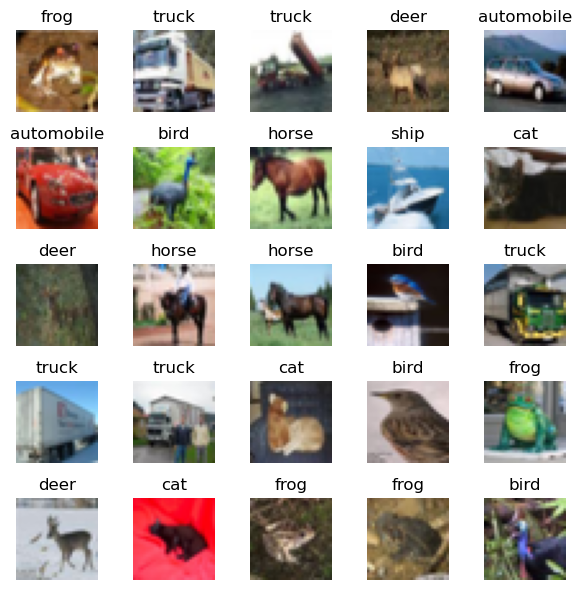

In [5]:
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

### Splitting Data

In [6]:
n_train = 1000
n_test = 20000

X = dataset.data
y = dataset.targets

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0.) tensor(1.)
torch.Size([60000]) torch.int64


In [7]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


In [8]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

In [9]:
resnet

ResNetClassifier(
  (featurizer): ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1):

In [10]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False):
    with torch.no_grad():
        for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
            X_dataset = X[idx].to(device)
            y_dataset = y[idx].to(device)
            y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
            print(f'{name} set accuracy: {acc*100:.2f}%')
            if plot_confusion_matrix:
                cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
                cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                    , cmap='Blues')
                # Rotate the labels on x-axis to make them readable
                _ = plt.xticks(rotation=90)
                plt.show()



### Predicting results without training

train set accuracy: 7.70%


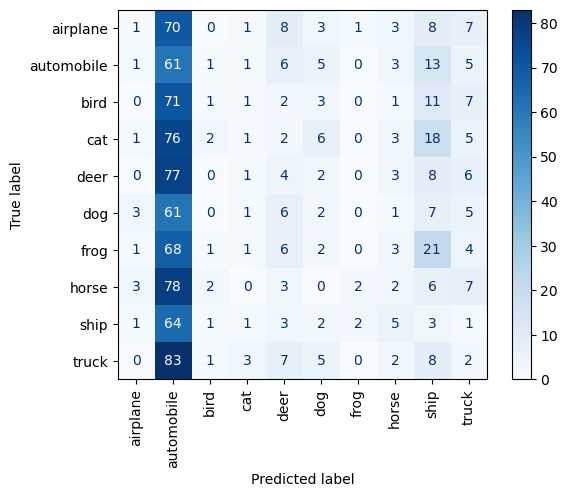

pool set accuracy: 8.36%


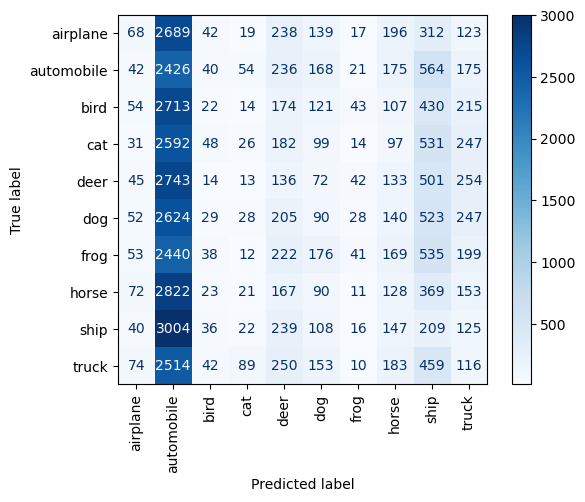

test set accuracy: 8.57%


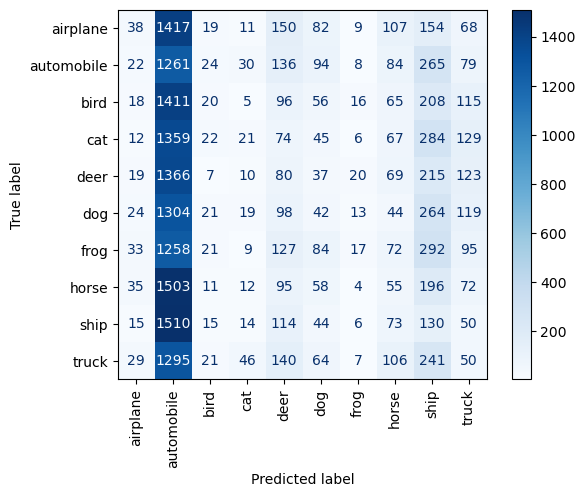

In [11]:
predict(resnet,dataset.classes,plot_confusion_matrix=True)

### Visualizing embeddings

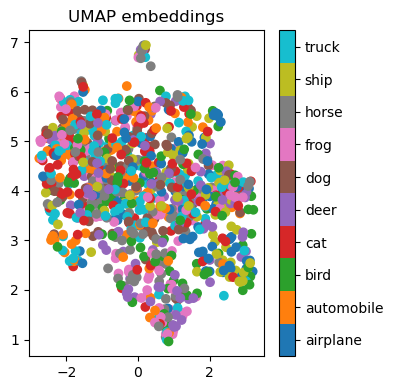

In [12]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

### Training model on train set

In [13]:
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(resnet,nn.CrossEntropyLoss(), X[train_idx], y[train_idx], lr=3e-4,
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

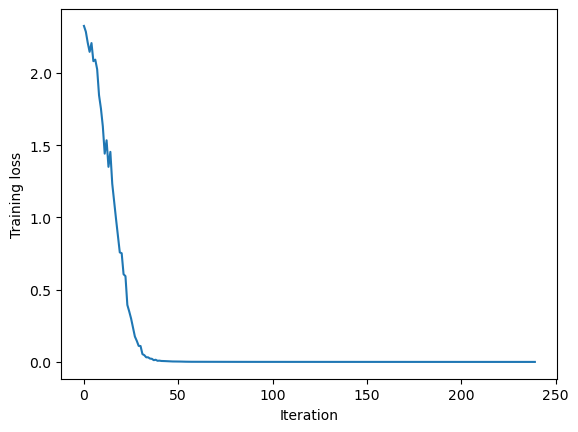

In [14]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


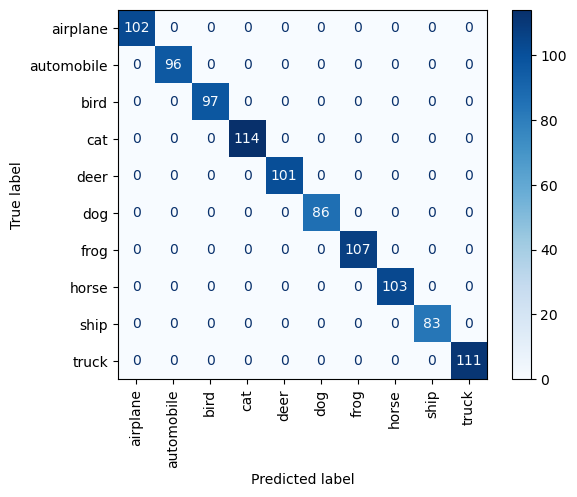

pool set accuracy: 35.30%


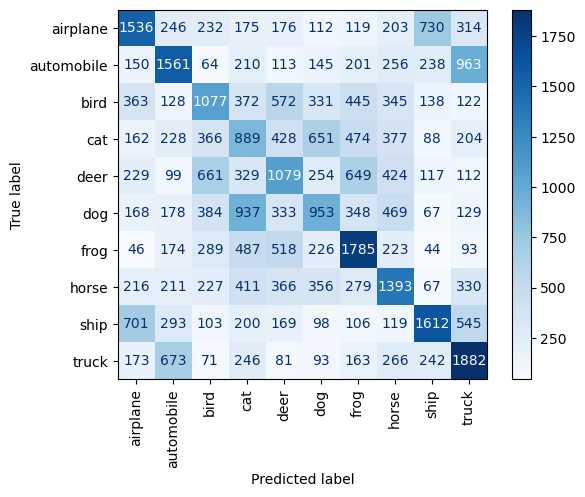

test set accuracy: 36.13%


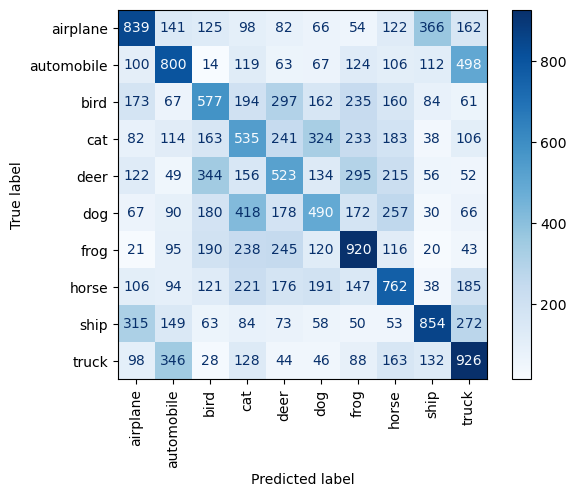

In [15]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

/home/vannsh.jani/miniconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


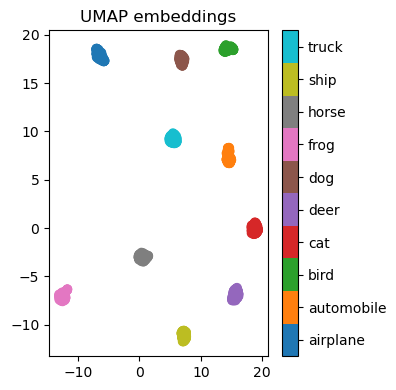

In [16]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

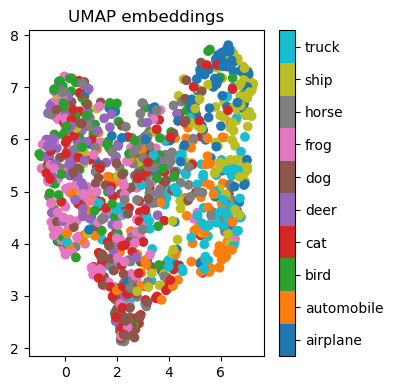

In [17]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [18]:
### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet,nn.CrossEntropyLoss(), X[train_plus_pool_idx], y[train_plus_pool_idx],
                                     lr=3e-4,
                                        batch_size=1024, epochs=30)

Loss: 0.04354956: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


Text(0, 0.5, 'Training loss')

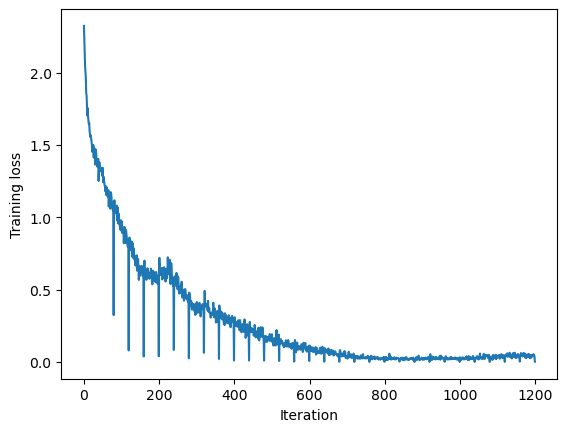

In [19]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

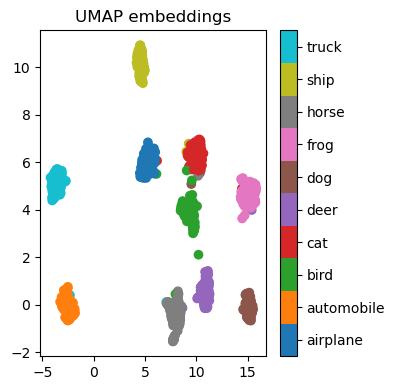

In [20]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

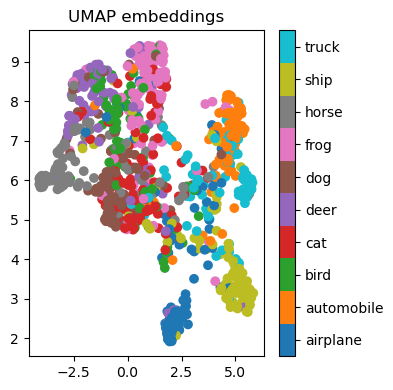

In [21]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 98.30%


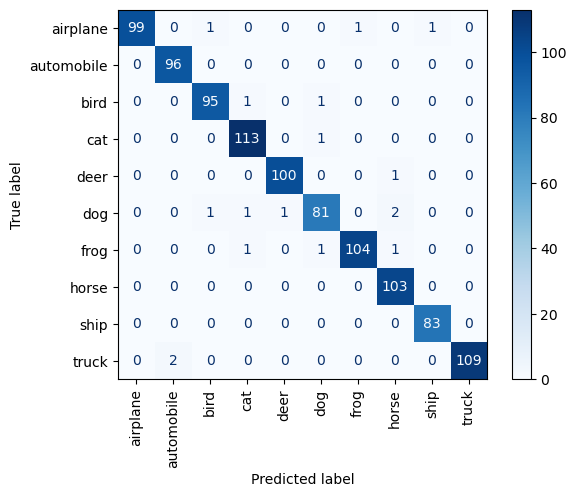

pool set accuracy: 98.45%


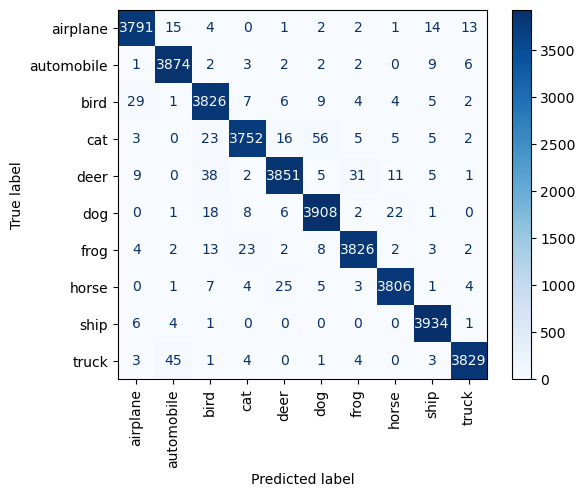

test set accuracy: 62.15%


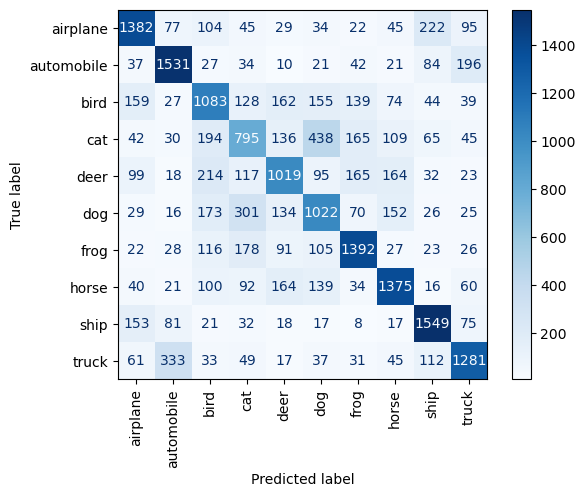

In [22]:
predict(resnet, dataset.classes, plot_confusion_matrix=True)

## SSL

Task: Dividing images into patches and permuting them. Predict the permutation number as a classification task

In [23]:
X_train_plus_pool = torch.cat([X[train_idx], X[pool_idx]])
y_train_plus_pool = torch.cat([y[train_idx], y[pool_idx]])


X_train_plus_pool.shape, y_train_plus_pool.shape

(torch.Size([40000, 3, 32, 32]), torch.Size([40000]))

In [24]:
# Divinding image into 4 patches of 8x8
def divide_into_patches(images):                  # images = (#,3,32,32), # = number of images
  patches = torch.split(images,16,dim=3)
  patches = [torch.unsqueeze(patch,1) for patch in patches]
  patches = torch.cat(patches,dim=1)
  patches = torch.split(patches,16,dim=3)
  patches = torch.cat(patches,dim=1)
  return patches


images_with_patches = divide_into_patches(X_train_plus_pool)
images_with_patches.shape

torch.Size([40000, 4, 3, 16, 16])

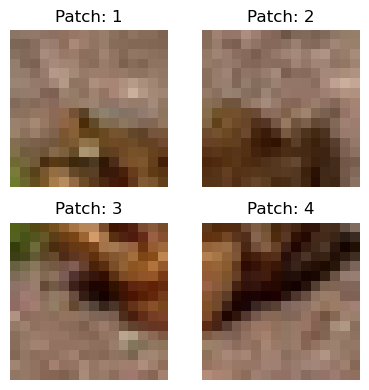

In [25]:
# Viusalizing patches
sample_image = images_with_patches[0]
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(torch.einsum("chw->hwc", sample_image[i]))
    plt.axis('off')
    plt.title(f"Patch: {i+1}")
plt.tight_layout()

torch.Size([3, 32, 32])


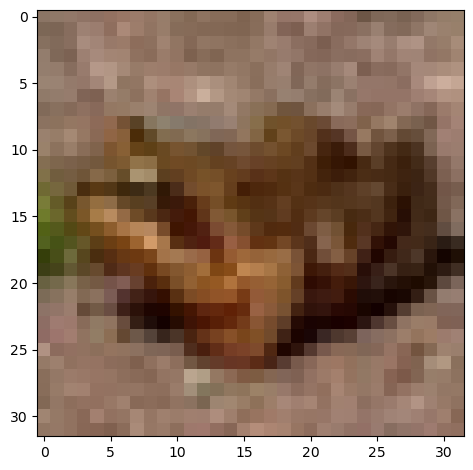

In [26]:
# Original image
print(X_train_plus_pool[0].shape)
plt.imshow(torch.einsum("chw->hwc", X_train_plus_pool[0]))
plt.tight_layout()

In [36]:
# def recombine_image(top_left,top_right,bottom_left,bottom_right):
#   top_left = torch.unsqueeze(top_left,0)
#   top_right = torch.unsqueeze(top_right,0)
#   bottom_left = torch.unsqueeze(bottom_left,0)
#   bottom_right = torch.unsqueeze(bottom_right,0)
#   top = torch.cat([top_left,top_right],dim=3)
#   bottom = torch.cat([bottom_left,bottom_right],dim=3)
#   image = torch.cat([top,bottom],dim=2)
#   return image


# def permute_patches(image_with_patches):
#     # image shape is (4, 3, 16, 16)
#     perms = torch.tensor(list(permutations(range(4))))  # all permutations of 4 patches (24, 4)

#     def permute_single_image(perm):
#         top_left = image_with_patches[perm[0]]
#         top_right = image_with_patches[perm[1]]
#         bottom_left = image_with_patches[perm[2]]
#         bottom_right = image_with_patches[perm[3]]
#         return recombine_image(top_left, top_right, bottom_left, bottom_right)

#     permuted_images = torch.stack([permute_single_image(perm) for perm in perms], dim=0)
#     return permuted_images

# permuted_images = torch.cat([permute_patches(image_with_patches) for image_with_patches in images_with_patches])
# permuted_images = torch.squeeze(permuted_images,1)
# permuted_images.shape    

torch.Size([960000, 3, 32, 32])

In [37]:
def recombine_image(top_left, top_right, bottom_left, bottom_right):
    top = torch.cat([top_left, top_right], dim=3)
    bottom = torch.cat([bottom_left, bottom_right], dim=3)
    image = torch.cat([top, bottom], dim=2)
    return image

def permute_patches(image_with_patches):
    perms = torch.tensor(list(permutations(range(4))))  # all permutations of 4 patches (24, 4)

    def permute_single_image(perm):
        top_left = image_with_patches[:, perm[0]]
        top_right = image_with_patches[:, perm[1]]
        bottom_left = image_with_patches[:, perm[2]]
        bottom_right = image_with_patches[:, perm[3]]
        return recombine_image(top_left, top_right, bottom_left, bottom_right)

    permuted_images = torch.vmap(permute_single_image)(perms)
    return permuted_images

permuted_images = permute_patches(images_with_patches)
permuted_images = torch.squeeze(permuted_images, 1)
permuted_images.shape

RuntimeError: vmap: It looks like you're calling .item() on a Tensor. We don't support vmap over calling .item() on a Tensor, please try to rewrite what you're doing with other operations. If error is occurring somewhere inside PyTorch internals, please file a bug report.